In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from counterfactuals.datasets import MoonsDataset, LawDataset
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.plot_utils import (
    plot_classifier_decision_region,
    plot_generative_model_distribution,
    plot_observations,
    plot_counterfactuals,
    plot_arrows,
)
from counterfactuals.cf_methods import RPPCEF
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.metrics import evaluate_cf

torch.manual_seed(0)

In [3]:
def plot(
    ax, flow, disc_model, dataset, X_test, y_test, X_cf, prob_threshold, colors=None
):
    assert (
        X_test.shape == X_cf.shape
    ), f"Sizes of test set and counterfactuals are not equal. Actual sizes: X_test: {X_test.shape}, X_cf: {X_cf.shape}"
    assert (
        y_test.shape[0] == X_cf.shape[0]
    ), f"Sizes of targets and counterfactuals are not equal. Actual sizes: X_cf: {X_cf.shape}, y_test: {y_test.shape}"

    ax = plot_classifier_decision_region(ax, disc_model)
    ax = plot_generative_model_distribution(
        ax,
        flow,
        prob_threshold=prob_threshold,
        num_classes=len(np.unique(dataset.y_test)),
    )
    ax = plot_observations(ax, X_test, y_test, colors)
    ax = plot_counterfactuals(ax, X_cf)
    ax = plot_arrows(ax, X_test, X_cf)
    # ax = plot_metrics_textbox(ax, metrics)
    return ax

/Users/ofurman/Study/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(t

alpha: 10000, alpha_s: 10000, alpha_k: 10000


loss: 132.1823, dist: 0.4623, max_inner: 0.0045, loss_disc: 0.0000, delta_loss: 86.8260: 100%|██████████| 20000/20000 [02:50<00:00, 117.16it/s]    
/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_7300/2502268014.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True)


Percentage of counterfactuals that belong to group: 0.8823529411764706
Number of k-vectors: 3


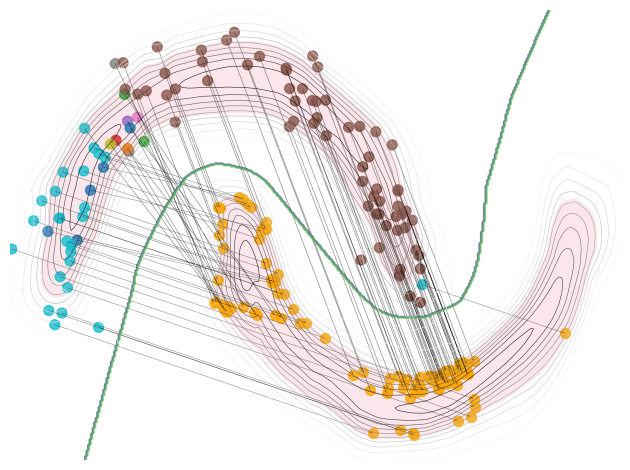

In [186]:
dataset = MoonsDataset(file_path="../data/moons.csv")
# dataset = MoonsWithBlobDataset(file_path="../data/moons_with_blob.csv")
# dataset = LawDataset(file_path="../data/law.csv")
# dataset = HelocDataset(file_path="../data/heloc.csv")

disc_model_name = "MultilayerPerceptron"
disc_model = MultilayerPerceptron(
    input_size=dataset.X_test.shape[1], hidden_layer_sizes=[256, 256], target_size=1
)
# disc_model.fit(
#     dataset.train_dataloader(128, shuffle=True),
#     test_loader=dataset.test_dataloader(1024, shuffle=False),
#     epochs=1000,
#     lr=1e-3,
#     patience=100,
#     checkpoint_path="mlp.pth"
# )

disc_model.load(f"../models/MoonsDataset/disc_model_{disc_model_name}.pt")
disc_model.eval()

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
# flow.fit(
#     dataset.train_dataloader(1024, shuffle=True, noise_lvl=0.03),
#     test_loader=dataset.test_dataloader(1024, shuffle=False),
#     num_epochs=1000,
#     checkpoint_path="flow.pth",
# )
flow.load(
    f"../models/MoonsDataset/gen_model_MaskedAutoregressiveFlow_relabeled_by_{disc_model_name}.pt"
)
flow.eval()

log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)
log_prob_threshold

# dataset.X_test = dataset.X_train
# dataset.y_test = dataset.y_train

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

origin_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]

# rand_i = np.argwhere(np.random.rand(X_test_origin.shape[0]) > 0.5).flatten()
rand_i = np.ones(X_test_origin.shape[0]).astype(bool)


# fig, ax = plt.subplots(2, 4)
# fig.set_size_inches(18, 9)

method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}

metrics_df = pd.DataFrame(
    columns=[
        "model_returned_smth",
        "valid_cf_disc",
        "dissimilarity_proximity_categorical_hamming",
        "dissimilarity_proximity_categorical_jaccard",
        "dissimilarity_proximity_continuous_manhatan",
        "dissimilarity_proximity_continuous_euclidean",
        "dissimilarity_proximity_continuous_mad",
        "distance_l2_jaccard",
        "distance_mad_hamming",
        "sparsity",
        "flow_log_density_cfs",
        "flow_log_density_xs",
        "flow_prob_condition_acc",
        "lof_scores_xs",
        "lof_scores_cfs",
        "isolation_forest_scores_xs",
        "isolation_forest_scores_cfs",
        "plausibility",
        "cf_belongs_to_group",
        "K_vectors",
    ]
)

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}
# for alpha in [0.1, 1, 10, 100]:
#     for alpha_s in [0.1, 1, 10, 100]:
#         for alpha_k in [0.1, 1, 10, 100]:
alpha = 10000
alpha_s = 10000
alpha_k = 10000
print(f"alpha: {alpha}, alpha_s: {alpha_s}, alpha_k: {alpha_k}")

K = X_test_origin.shape[0]
K = 3
cf = RPPCEF(
    N=X_test_origin.shape[0],
    D=X_test_origin.shape[1],
    K=K,
    cf_method_type="GCE",
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)
# X_cf = pd.read_csv(
#     f"../models/MoonsDataset/GCE/counterfactuals_{plausibility[i]}_{method}_{disc_model_name}.csv"
# ).values

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

delta, Xs, ys_orig, ys_target, _ = cf.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20_000,
    lr=3e-3,
    patience=500,
    alpha=alpha,
    alpha_s=alpha_s,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()

S = S.detach().numpy()
cf_belongs_to_group = np.sum(np.any(S == 1.0, axis=1)) / S.shape[0]
print(f"Percentage of counterfactuals that belong to group: {cf_belongs_to_group}")
k_vectors = (S.sum(axis=0) != 0).sum()
print(f"Number of k-vectors: {k_vectors}")

unique_rows, indices = np.unique(S, axis=0, return_inverse=True)
labels = np.arange(len(unique_rows))
colors = labels[indices]

X_cf = Xs + delta().detach().numpy()


metrics = evaluate_cf(
    gen_model=flow,
    disc_model=disc_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]).astype(bool),
    categorical_features=dataset.categorical_features,
    continuous_features=dataset.numerical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=Xs,
    y_test=ys_orig,
    median_log_prob=log_prob_threshold,
    S_matrix=S,
    X_test_target=X_test_target,
)

# save metrics dict to json
metrics_df = pd.concat(
    [metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True
)
metrics_df.to_csv(
    f"metrics_groups_alpha_{alpha}_alpha_s_{alpha_s}_alpha_k_{alpha_k}.csv"
)

# umap = UMAP(n_components=2)
# Xs_umap = umap.fit_transform(Xs)
# X_cf_umap = umap.transform(X_cf)


fig, ax = plt.subplots(1, 1)
ax = plot(
    ax,
    flow,
    disc_model,
    dataset,
    X_test_origin[rand_i],
    y_test_origin[rand_i],
    X_cf[rand_i],
    log_prob_threshold,
    colors=colors,
)
# remove axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
# plt.savefig(f"figure_groups_alpha_{alpha}_alpha_s_{alpha_s}_alpha_k_{alpha_k}.pdf", dpi=300)
plt.show()

In [47]:
metrics

{'model_returned_smth': 1.0,
 'valid_cf_disc': 0.842563271522522,
 'dissimilarity_proximity_categorical_hamming': nan,
 'dissimilarity_proximity_categorical_jaccard': 0.0,
 'dissimilarity_proximity_continuous_manhatan': 1.2528419026559516,
 'dissimilarity_proximity_continuous_euclidean': 0.37028245918984043,
 'dissimilarity_proximity_continuous_mad': 17.85202584136831,
 'distance_l2_jaccard': 0.37028245918984043,
 'distance_mad_hamming': nan,
 'sparsity': 1.0,
 'flow_log_density_cfs': 29.448871612548828,
 'flow_log_density_xs': 29.65152359008789,
 'flow_prob_condition_acc': 0.6788732409477234,
 'lof_scores_xs': 1.1037443,
 'lof_scores_cfs': 504865180.0,
 'isolation_forest_scores_xs': 0.04500961627082506,
 'isolation_forest_scores_cfs': 0.05870168409941496,
 'plausibility': 0.299267728951467,
 'cf_belongs_to_group': 0.7998417721518988,
 'K_vectors': 10}

# K-Means Pre-Grouping

In [7]:
dataset = MoonsDataset(file_path="../data/moons.csv")
dataset = LawDataset(file_path="../data/law.csv")

# disc_model_name = "LogisticRegression"
# disc_model = LogisticRegression(input_size=2, target_size=1)
# disc_model.load(f"../models/MoonsDataset/disc_model_{disc_model_name}.pt")

disc_model_name = "MultilayerPerceptron"
disc_model = MultilayerPerceptron(
    input_size=3, hidden_layer_sizes=[256, 256], target_size=1
)
disc_model.load(f"../models/LawDataset/disc_model_{disc_model_name}.pt")

flow = MaskedAutoregressiveFlow(
    features=3,
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.load(
    f"../models/LawDataset/gen_model_MaskedAutoregressiveFlow_relabeled_by_{disc_model_name}.pt"
)
log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

origin_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]

# rand_i = np.argwhere(np.random.rand(X_test_origin.shape[0]) > 0.5).flatten()
rand_i = np.ones(X_test_origin.shape[0]).astype(bool)

# fig, ax = plt.subplots(2, 4)
# fig.set_size_inches(18, 9)

method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}
metrics_df = pd.DataFrame(
    columns=[
        "model_returned_smth",
        "valid_cf_disc",
        "dissimilarity_proximity_categorical_hamming",
        "dissimilarity_proximity_categorical_jaccard",
        "dissimilarity_proximity_continuous_manhatan",
        "dissimilarity_proximity_continuous_euclidean",
        "dissimilarity_proximity_continuous_mad",
        "distance_l2_jaccard",
        "distance_mad_hamming",
        "sparsity",
        "flow_log_density_cfs",
        "flow_log_density_xs",
        "flow_prob_condition_acc",
        "lof_scores_xs",
        "lof_scores_cfs",
        "isolation_forest_scores_xs",
        "isolation_forest_scores_cfs",
        "plausibility",
        "cf_belongs_to_group",
        "K_vectors",
    ]
)

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}
for i in range(2, 11):
    for j, method in enumerate(["GCE"]):  # "ARES", "GLOBAL_CE", "GCE", "PPCEF_2"
        if method in ["ARES", "GLOBAL_CE"]:
            K = 1
        else:
            K = i
            # K = X_test_origin.shape[0]
        cf = RPPCEF(
            N=X_test_origin.shape[0],
            D=X_test_origin.shape[1],
            K=K,
            cf_method_type=method,
            init_cf_method_from_kmeans=True,
            X=X_test_origin,
            gen_model=flow,
            disc_model=disc_model,
            disc_model_criterion=BinaryDiscLoss(),
            neptune_run=None,
        )

        # X_cf = pd.read_csv(
        #     f"../models/MoonsDataset/GCE/counterfactuals_{plausibility[i]}_{method}_{disc_model_name}.csv"
        # ).values

        cf_dataloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(X_test_origin).float(),
                torch.tensor(y_test_origin).float(),
            ),
            batch_size=4096,
            shuffle=False,
        )

        delta, Xs, ys_orig, ys_target, _ = cf.explain_dataloader(
            dataloader=cf_dataloader,
            epochs=20_000,
            lr=3e-3,
            patience=500,
            alpha=1000,
            alpha_s=0,
            alpha_k=0,
            log_prob_threshold=log_prob_threshold,
        )

        _, S, _ = delta.get_matrices()

        S = S.detach().numpy()
        cf_belongs_to_group = np.sum(np.any(S == 1.0, axis=1)) / S.shape[0]
        print(
            f"Percentage of counterfactuals that belong to group: {cf_belongs_to_group}"
        )
        k_vectors = (S.sum(axis=0) != 0).sum()
        print(f"Number of k-vectors: {k_vectors}")

        # apply inverse one hot on S
        colors = np.argmax(S, axis=1)

        X_cf = Xs + delta().detach().numpy()

        metrics = evaluate_cf(
            gen_model=flow,
            disc_model=disc_model,
            X_cf=X_cf,
            model_returned=np.ones(X_cf.shape[0]).astype(bool),
            categorical_features=dataset.categorical_features,
            continuous_features=dataset.numerical_features,
            X_train=dataset.X_train,
            y_train=dataset.y_train.reshape(-1),
            X_test=Xs,
            y_test=ys_orig,
            median_log_prob=log_prob_threshold,
            S_matrix=S,
            X_test_target=X_test_target,
        )

        # save metrics dict to json
        metrics_df = pd.concat(
            [metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True
        )
        metrics_df.to_csv(f"metrics_{method}_k_means_groups_late_dist.csv")

        # fig, ax = plt.subplots(1, 1)
        # ax = plot(
        #     ax,
        #     flow,
        #     disc_model,
        #     dataset,
        #     Xs_embedding[rand_i],
        #     y_test_origin[rand_i],
        #     X_cf_embedding[rand_i],
        #     log_prob_threshold,
        #     colors=colors,
        # )
        # # remove axes
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # # remove frame
        # ax.spines["top"].set_visible(False)
        # ax.spines["right"].set_visible(False)
        # ax.spines["bottom"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        # plt.tight_layout()

        # plt.savefig(f"figure_{method}_k_means_init_{i}_groups.pdf", dpi=300)
# plt.tight_layout()
# plt.savefig("all_methods_lr_model.pdf", dpi=300)

/Users/ofurman/Study/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(t

Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 2


/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_65096/3079218629.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True)


(198, 244)
0.05632456540673168


loss: 12.1026, dist: 0.3875, max_inner: 0.0117, loss_disc: 0.0001, delta_loss: 0.0000:  23%|██▎       | 4508/20000 [00:33<01:56, 133.08it/s] 


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 3
(198, 246)
0.04715548864238229


loss: 6.9350, dist: 0.3267, max_inner: 0.0065, loss_disc: 0.0001, delta_loss: 0.0000:  46%|████▋     | 9290/20000 [01:09<01:19, 134.25it/s]  


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 4
(198, 246)
0.04137513822664113


loss: 4.0836, dist: 0.3758, max_inner: 0.0037, loss_disc: 0.0000, delta_loss: 0.0000:  21%|██▏       | 4268/20000 [00:31<01:57, 133.57it/s]  


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 5
(198, 246)
0.04453308790026984


loss: 0.7287, dist: 0.3136, max_inner: 0.0003, loss_disc: 0.0001, delta_loss: 0.0000:  44%|████▍     | 8898/20000 [01:06<01:23, 133.24it/s]  


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 6
(198, 246)
0.040057614290883135


loss: 0.3261, dist: 0.3081, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  47%|████▋     | 9499/20000 [01:11<01:18, 133.25it/s]   


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 7
(198, 246)
0.03867762775322894


loss: 0.3069, dist: 0.3069, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  48%|████▊     | 9619/20000 [01:13<01:19, 131.05it/s]  


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 8
(198, 246)
0.03996025274797439


loss: 0.3002, dist: 0.3002, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  48%|████▊     | 9535/20000 [01:12<01:19, 131.03it/s] 


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 9
(198, 246)
0.03941834094453026


loss: 0.2972, dist: 0.2972, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  48%|████▊     | 9539/20000 [01:11<01:18, 133.20it/s] 


Percentage of counterfactuals that belong to group: 1.0
Number of k-vectors: 10
(198, 246)
0.04019490250167682
